In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import matplotlib.dates as mdates
import pickle
import warnings
import folium 

#from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import GCNConv, MessagePassing, SAGEConv
from sklearn.neighbors import BallTree
from scipy.sparse import csr_matrix
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors
from torch_geometric.data import Data
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.notebook import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Cleaning

In [3]:
"""
Get data
"""
pd.set_option('display.max_columns', None)  # None means all columns will be displayed

df = pd.read_parquet('../../Datasets/data_processed_half_Basti_final.parq')


#-----------------------One hot encode the 'owner' column-----------------------
df = pd.get_dummies(df, columns=['owner'])


#-----------------------Data cleaning-----------------------

# Drop columns and charging stations  
df = df.drop(['plugType1','hours_elapsed', 'status_3_ratio','timestamp_rounded'], axis=1)  

# Remove coordinates
coordinates_to_remove = [
    (9.695102, 56.784101),
    (10.177534, 56.137189),
    (12.488927, 55.765375),
    (12.586730, 56.025982),
    (12.593150, 55.701301)
]


for longitude, latitude in coordinates_to_remove:
    df = df[~((df['longitude'] == longitude) & (df['latitude'] == latitude))]
    

print("Column Names:", df.columns.tolist())
display(df)
print(len(df))


Column Names: ['longitude', 'latitude', 'plugType2', 'plugCCS', 'plugTesla', 'plugChademo', 'gravity', 'traffic', 'apartments', 'cinemas', 'clinics', 'colleges', 'communityCentres', 'conferenceCentres', 'dentists', 'eventsVenues', 'fastFoods', 'hospitals', 'hotels', 'houses', 'leisureFitnessCentres', 'leisureStadiums', 'motorwayLinks', 'placesOfWorship', 'restaurants', 'shopMalls', 'shopSupermarkets', 'sportsCentres', 'sportsHalls', 'stadiums', 'substationDistributions', 'theatres', 'universities', 'ratios_length', 'minCapacity', 'maxCapacity', 'owner_Allego', 'owner_Circle K', 'owner_Clever', 'owner_Drivee', 'owner_E.ON', 'owner_E.ON Drive & Clever', 'owner_EVBox B.V. ', 'owner_IONITY', 'owner_Monta', 'owner_Q8', 'owner_Shell Recharge', 'owner_Spirii', 'owner_Tesla', 'owner_Tesla (Open for all EV)']


,longitude,latitude,plugType2,plugCCS,plugTesla,plugChademo,gravity,traffic,apartments,cinemas,clinics,colleges,communityCentres,conferenceCentres,dentists,eventsVenues,fastFoods,hospitals,hotels,houses,leisureFitnessCentres,leisureStadiums,motorwayLinks,placesOfWorship,restaurants,shopMalls,shopSupermarkets,sportsCentres,sportsHalls,stadiums,substationDistributions,theatres,universities,ratios_length,minCapacity,maxCapacity,owner_Allego,owner_Circle K,owner_Clever,owner_Drivee,owner_E.ON,owner_E.ON Drive & Clever,owner_EVBox B.V.,owner_IONITY,owner_Monta,owner_Q8,owner_Shell Recharge,owner_Spirii,owner_Tesla,owner_Tesla (Open for all EV)
0,8.141860,55.555610,2,2,0,0,13462.7,0.0,215.249,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.540,764.615,0.0,10661.3,0.0,0.0,0.0,0.00,0.0,0.0,4.0,11.0,150.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,8.141860,55.555610,2,2,0,0,13462.7,0.0,215.249,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.540,764.615,0.0,10661.3,0.0,0.0,0.0,0.00,0.0,0.0,4.0,11.0,150.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,8.141860,55.555610,2,2,0,0,13462.7,0.0,215.249,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.540,764.615,0.0,10661.3,0.0,0.0,0.0,0.00,0.0,0.0,4.0,11.0,150.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,8.141860,55.555610,2,2,0,0,13462.7,0.0,215.249,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.540,764.615,0.0,10661.3,0.0,0.0,0.0,0.00,0.0,0.0,4.0,11.0,150.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,8.141860,55.555610,2,2,0,0,13462.7,0.0,215.249,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1821.540,764.615,0.0,10661.3,0.0,0.0,0.0,0.00,0.0,0.0,4.0,11.0,150.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903107,12.659088,55.595629,0,2,0,0,26745.1,0.0,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.643,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903108,12.659088,55.595629,0,2,0,0,26745.1,0.0,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.643,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903109,12.659088,55.595629,0,2,0,0,26745.1,0.0,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.643,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
903110,12.659088,55.595629,0,2,0,0,26745.1,0.0,386.782,2.05985,0.0,0.0,0.0,0.0,6.13375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,198.643,187.923,2933.2,16313.9,0.0,0.0,0.0,6716.45,0.0,0.0,2.0,300.0,300.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False


896664


# Add new stations

In [4]:
"""
Define new stations

new_stations = pd.DataFrame({
    'longitude':                    [8.141847, 12.163113, 8.620159],
    'latitude':                     [55.555547, 55.489025, 56.361676],
    'plugType2':                    [2, 0, 0], 
    'plugCCS':                      [2, 26, 6], 
    'plugTesla':                    [0, 26, 0],  
    'plugChademo':                  [0, 0, 0],  
    'gravity':                      [13462.7, 13266.7, 34767.5],   
    'traffic':                      [0.0, 352.818, 137.985],   
    'apartments':                   [215.249, 0.0, 344.842],   
    'cinemas':                      [0.0, 0.0, 19.1157],   
    'clinics':                      [0.0, 0.0, 0.0],   
    'colleges':                     [0.0, 0.0, 0.0],   
    'communityCentres':             [0.0, 0.0, 838.806],   
    'conferenceCentres':            [0.0, 0, 0.0],   
    'dentists':                     [0.0, 0, 527.357],  
    'eventsVenues':                 [0.0, 0.0, 101.536],   
    'fastFoods':                    [0.0, 9020.18, 578.855],   
    'hospitals':                    [0.0, 0.0, 0.0],           
    'hotels':                       [0.0, 0.0, 16.4947],           
    'houses':                       [0.0, 0.0, 0.0],           
    'leisureFitnessCentres':        [0.0, 0.0, 2676.39],           
    'leisureStadiums':              [0.0, 0.0, 5.56256],           
    'motorwayLinks':                [0.0, 3038.97, 0.0],           
    'placesOfWorship':              [1821.540, 0.0, 920.356],           
    'restaurants':                  [764.615, 0.0, 12752.8],           
    'shopMalls':                    [0.0, 0.0, 3501.42],           
    'shopSupermarkets':             [10661.3, 0, 10763.6],           
    'sportsCentres':                [0.0, 0.0, 0.0],           
    'sportsHalls':                  [0.0, 0.0, 0.0],           
    'stadiums':                     [0.0, 0.0, 0.0],           
    'substationDistributions':      [0.0, 0.0, 0.0],           
    'theatres':                     [13462.7, 0.0, 11.8152],           
    'universities':                 [0.0, 0.0, 0.0],           
    'ratios_length':                [4.0, 26.0, 6.0	],    
    'minCapacity':                  [11.0, 150.0, 300.0],    
    'maxCapacity':                  [150.0, 150.0, 300.0],    
    'owner_Allego':                 [False, False, False],    
    'owner_Circle K':               [False, False, False],    
    'owner_Clever':                 [True, False, True],    
    'owner_Drivee':                 [False, False, False],    
    'owner_E.ON':                  [False, False, False],    
    'owner_E.ON Drive & Clever':    [False, False, False],    
    'owner_EVBox B.V. ':            [False, False, False],    
    'owner_IONITY':                 [False, False, False],    
    'owner_Monta':                  [False, False, False],    
    'owner_Q8':                     [False, False, False],    
    'owner_Shell Recharge':         [False, False, False],    
    'owner_Spirii':                 [False, False, False],    
    'owner_Tesla':                  [False, False, False],    
    'owner_Tesla (Open for all EV)':[False, True, False]
})

# Concatenate the new stations DataFrame with the existing DataFrame
df = pd.concat([df, new_stations], ignore_index=True)
display(df)
"""

"\nDefine new stations\n\nnew_stations = pd.DataFrame({\n    'longitude':                    [8.141847, 12.163113, 8.620159],\n    'latitude':                     [55.555547, 55.489025, 56.361676],\n    'plugType2':                    [2, 0, 0], \n    'plugCCS':                      [2, 26, 6], \n    'plugTesla':                    [0, 26, 0],  \n    'plugChademo':                  [0, 0, 0],  \n    'gravity':                      [13462.7, 13266.7, 34767.5],   \n    'traffic':                      [0.0, 352.818, 137.985],   \n    'apartments':                   [215.249, 0.0, 344.842],   \n    'cinemas':                      [0.0, 0.0, 19.1157],   \n    'clinics':                      [0.0, 0.0, 0.0],   \n    'colleges':                     [0.0, 0.0, 0.0],   \n    'communityCentres':             [0.0, 0.0, 838.806],   \n    'conferenceCentres':            [0.0, 0, 0.0],   \n    'dentists':                     [0.0, 0, 527.357],  \n    'eventsVenues':                 [0.0, 0.0, 101.53

# Data Preprocessing

### Calculate distances

In [4]:
"""
Helper functions
"""
#Function for haversine formula
def haversine(coord1, coord2):
    # Coordinates in decimal degrees (latitude, longitude)
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Earth radius in kilometers

    dLat = np.radians(lat2 - lat1)
    dLon = np.radians(lon2 - lon1)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c  # Output distance in kilometers
    return distance


#Function to calculate nearest neighbour 
def latlon_to_xyz(latitude, longitude):
    lat_rad = np.radians(latitude)
    lon_rad = np.radians(longitude)
    x = np.cos(lat_rad) * np.cos(lon_rad)
    y = np.cos(lat_rad) * np.sin(lon_rad)
    z = np.sin(lat_rad)
    return x, y, 

# Function to calculate distance-based edge weights
def calculate_edge_weights(distances):
    # Use the inverse of distance as the weight
    weights = 1.0 / distances
    return weights


In [5]:
"""
Getting the nearest neighbours
"""
# Set pandas display options to not truncate
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Extract coordinates and convert to cartesian coordinates
coordinates = df[['latitude', 'longitude']].drop_duplicates().reset_index(drop=True)
print(len(coordinates))
print(coordinates)
xyz_coords = np.array([latlon_to_xyz(lat, lon) for lat, lon in coordinates.to_numpy()])

# make dictionary to store the indexing of the charging stations 
index_mapping = {tuple(row): i for i, row in enumerate(coordinates[['latitude', 'longitude']].values)}


#Create query tree 
tree = KDTree(xyz_coords)  # Create a KD-tree from the Cartesian coordinates
N = 5  # Number of nearest neighbors you want to find


edges = []
edge_weights = []  # List to store edge weights

for i in range(len(xyz_coords)):
    # Query the tree for the nearest N+1 neighbors (the point itself is included)
    distances, indices = tree.query(xyz_coords[i], k=N+1)
    
    # Skip the first index (i.e., the point itself) and create edges for the graph
    for j in range(1, N+1):
        edges.append((i, indices[j]))
        
        # Calculate edge weight based on distance
        weights = calculate_edge_weights(distances[1:])  # Exclude the first distance (self-distance)
        edge_weights.extend(weights)

# Convert edges and edge weights to tensors
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
edge_weights = torch.tensor(edge_weights, dtype=torch.float).contiguous()


#-------------------------Example: Get edge weights for a single station (station_index)-------------------------
station_index = 239  # Index of the station of interest

# Find edges associated with the station
station_edges = edge_index[:, edge_index[0] == station_index]

# Extract corresponding edge weights
station_edge_weights = edge_weights[station_edges[1]]

# Print the edge weights
print(station_edges)
print(station_edge_weights)



392
      latitude  longitude
0    55.555610   8.141860
1    56.705280   8.213788
2    56.700175   8.221635
3    56.781686   8.232640
4    56.094496   8.235740
5    56.092085   8.242567
6    56.196524   8.298722
7    56.549673   8.302795
8    56.551810   8.310629
9    55.613885   8.325843
10   56.950043   8.374080
11   55.438328   8.385841
12   56.751527   8.417567
13   55.471802   8.434331
14   55.472953   8.435814
15   55.465674   8.444136
16   55.465691   8.445434
17   55.510032   8.456897
18   57.043306   8.481117
19   55.478315   8.493108
20   55.610463   8.493445
21   55.146434   8.495552
22   55.521225   8.548019
23   56.486855   8.583807
24   55.524597   8.589284
25   56.493334   8.591714
26   56.480421   8.606704
27   57.115455   8.608220
28   56.377499   8.620042
29   56.361676   8.620159
30   56.376929   8.621127
31   56.366330   8.637648
32   56.954006   8.692057
33   56.951909   8.692122
34   56.955035   8.696964
35   55.330435   8.764603
36   55.158749   8.769447
37   55.

In [6]:
"""
Save the index mapping 
"""
# Assuming 'index_mapping' is your dictionary
with open('index_mapping_original.pkl', 'wb') as file:
    pickle.dump(index_mapping, file)


In [6]:
"""
Visualize the edges
"""
# Assuming 'coordinates' DataFrame and 'edges' list are already defined
lat_center = coordinates['latitude'].mean()
lon_center = coordinates['longitude'].mean()
m = folium.Map(location=[lat_center, lon_center], zoom_start=8)

# Add markers
for idx, row in coordinates.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']],
                  tooltip=f'Station {idx}').add_to(m)

# Draw connections
for edge in edges:
    station1 = coordinates.iloc[edge[0]]
    station2 = coordinates.iloc[edge[1]]
    loc1 = [station1['latitude'], station1['longitude']]
    loc2 = [station2['latitude'], station2['longitude']]
    folium.PolyLine(locations=[loc1, loc2], color='blue', weight=1.5).add_to(m)

# Display the map
m

### Get node features

In [7]:
"""
Normalize the features
"""
pd.set_option('display.max_columns', None)  # None means all columns will be displayed

# Get one instance of each charging station
unique_stations = df.drop_duplicates(subset=['longitude', 'latitude']).reset_index(drop=True)
print(len(unique_stations))


# Selecting relevant static feature columns
static_features = ['plugType2', 'plugCCS', 'plugTesla', 'plugChademo', 'gravity', 'traffic', 'apartments', 'cinemas', 'clinics',
                   'colleges', 'communityCentres', 'conferenceCentres', 'dentists', 'eventsVenues', 'fastFoods', 'hospitals', 'hotels', 'houses', 'leisureFitnessCentres', 'leisureStadiums', 'motorwayLinks', 'placesOfWorship', 'restaurants', 'shopMalls', 'shopSupermarkets', 'sportsCentres', 'sportsHalls', 'stadiums', 'substationDistributions', 'theatres', 'universities', 'ratios_length', 'minCapacity', 'maxCapacity', 'owner_Allego', 'owner_Circle K', 'owner_Clever', 'owner_Drivee', 'owner_E.ON', 'owner_E.ON Drive & Clever', 'owner_EVBox B.V. ', 'owner_IONITY', 'owner_Monta', 'owner_Q8', 
                   'owner_Shell Recharge', 'owner_Spirii', 'owner_Tesla', 'owner_Tesla (Open for all EV)']


# Scaler
scaler = MinMaxScaler()

# Normalize these features
unique_stations[static_features] = scaler.fit_transform(unique_stations[static_features])

# Convert to tensor and ensure coordinates are kept
node_features = torch.tensor(unique_stations[static_features].values, dtype=torch.float)

#Optional:
print(node_features[:2])  # Display the first 5 nodes' features to verify

print(node_features.shape)
print(coordinates)

392
tensor([[0.0625, 0.0714, 0.0000, 0.0000, 0.2771, 0.0000, 0.0187, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.2317, 0.0542, 0.0000, 0.5070, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0909, 0.0183, 0.2500, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.2500, 0.0714, 0.0000, 0.0000, 0.1364, 0.0028, 0.0507, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0097, 0.4218, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2273, 0.0183, 0.1333, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])
torch.Size([392, 48])
      latitude  longitude
0    55.555610   8.141860
1    56.705280   8.213788
2    56.700175   

# Training and Testing Split

In [8]:
"""
Make data object
"""
# Make data object with edge weights
graph_data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_weights)
print(graph_data)


Data(x=[392, 48], edge_index=[2, 1960], edge_attr=[9800])


In [9]:
"""
Verify the data object 
"""
print("First few node features:")
print(graph_data.x[:2])  # Adjust as needed to inspect more rows

print("First few edges:")
print(graph_data.edge_index[:, :10])  # Adjust as needed to inspect more edges


First few node features:
tensor([[0.0625, 0.0714, 0.0000, 0.0000, 0.2771, 0.0000, 0.0187, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.2317, 0.0542, 0.0000, 0.5070, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0909, 0.0183, 0.2500, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000],
        [0.2500, 0.0714, 0.0000, 0.0000, 0.1364, 0.0028, 0.0507, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0097, 0.4218, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2273, 0.0183, 0.1333, 0.0000, 0.0000,
         0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000]])
First few edges:
tensor([[ 0,  0,  0,  0,  0,  1,  1,  1,  1,  1],
        [ 9, 11, 13, 14, 17, 

In [10]:
"""
Split the data 
"""
# Assume 80% training, 10% validation, 10% test
num_nodes = graph_data.num_nodes

train_size = int(num_nodes * 0.8)
val_size = int(num_nodes * 0.1)
test_size = num_nodes - train_size - val_size

#-----------------------------Splitting the data-----------------------------
# Create masks for training, validation, and testing
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[:train_size] = True
val_mask[train_size:train_size + val_size] = True
test_mask[train_size + val_size:] = True

# Shuffle the masks to randomize
perm = torch.randperm(num_nodes)
train_mask = train_mask[perm]
val_mask = val_mask[perm]
test_mask = test_mask[perm]

# Assign masks to data
graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask


# Model

In [11]:
from torch_geometric.nn import BatchNorm

"""
Defining the model
"""
class GCNAutoencoder(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCNAutoencoder, self).__init__()
        self.encoder = GCNConv(num_features, hidden_channels)
        self.batch_norm = BatchNorm(hidden_channels)
        self.decoder = GCNConv(hidden_channels, num_features)

    def forward(self, x, edge_index):
        x = self.encoder(x, edge_index)
        x = F.relu(self.batch_norm(x))  # Apply batch normalization after activation
        x = F.dropout(x, training=self.training)
        x = self.decoder(x, edge_index)
        return x

#--------------------Initializing the model--------------------
model = GCNAutoencoder(num_features=48, hidden_channels=16)  # Assuming each node has 48 features


### Training the model

In [12]:
"""
Training functions 
"""
#Training functions 
def train(data):
    model.train()
    optimizer.zero_grad()
    reconstructed = model(data.x, data.edge_index)
    loss = criterion(reconstructed[data.train_mask], data.x[data.train_mask])  # Only compute loss on training masked nodes
    loss.backward()
    optimizer.step()
    return loss.item()

#Validation functions 
def validate(data):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data.x, data.edge_index)
        val_loss = criterion(reconstructed[data.val_mask], data.x[data.val_mask])  # Only compute loss on validation masked nodes
    return val_loss.item()


"""
Training parameters
"""
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)  # Adjust weight_decay as needed
criterion = torch.nn.MSELoss()  # Use CrossEntropyLoss for classification tasks
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



In [13]:
"""
Training loop
"""
num_epochs = 300

#training the model 
for epoch in range(num_epochs):
    train_loss = train(graph_data)  # Pass the full graph data
    val_loss = validate(graph_data)  # Validation on possibly a separate validation graph or subset

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1: Train Loss: 0.5839, Validation Loss: 0.0533
Epoch 2: Train Loss: 0.3943, Validation Loss: 0.0500
Epoch 3: Train Loss: 0.3634, Validation Loss: 0.0478
Epoch 4: Train Loss: 0.2605, Validation Loss: 0.0463
Epoch 5: Train Loss: 0.2234, Validation Loss: 0.0453
Epoch 6: Train Loss: 0.1787, Validation Loss: 0.0444
Epoch 7: Train Loss: 0.1512, Validation Loss: 0.0436
Epoch 8: Train Loss: 0.1501, Validation Loss: 0.0427
Epoch 9: Train Loss: 0.1132, Validation Loss: 0.0419
Epoch 10: Train Loss: 0.1232, Validation Loss: 0.0412
Epoch 11: Train Loss: 0.1102, Validation Loss: 0.0405
Epoch 12: Train Loss: 0.0986, Validation Loss: 0.0399
Epoch 13: Train Loss: 0.0885, Validation Loss: 0.0394
Epoch 14: Train Loss: 0.0861, Validation Loss: 0.0390
Epoch 15: Train Loss: 0.0759, Validation Loss: 0.0387
Epoch 16: Train Loss: 0.0787, Validation Loss: 0.0385
Epoch 17: Train Loss: 0.0646, Validation Loss: 0.0383
Epoch 18: Train Loss: 0.0624, Validation Loss: 0.0381
Epoch 19: Train Loss: 0.0590, Validat

# Model Evaluation

In [15]:
# Evaluate reconstruction loss on the test set
def evaluate_reconstruction_loss(data):
    model.eval()
    with torch.no_grad():
        reconstructed = model(data.x, data.edge_index)
        loss = criterion(reconstructed, data.x)
    return loss.item()

test_loss = evaluate_reconstruction_loss(graph_data)  # Assuming graph_data contains test masks or is a separate test set
print(f'Test Reconstruction Loss: {test_loss:.4f}')


Test Reconstruction Loss: 0.0272


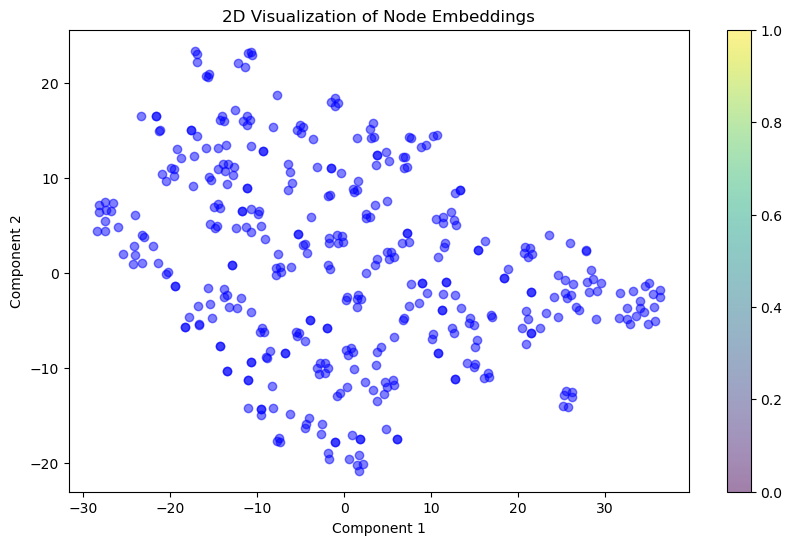

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_embeddings(data):
    model.eval()
    with torch.no_grad():
        embeddings = model.encoder(data.x, data.edge_index)  # Get only the embeddings

    tsne = TSNE(n_components=2)
    embeddings_2d = tsne.fit_transform(embeddings.detach().numpy())

    plt.figure(figsize=(10, 6))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.5)
    plt.title('2D Visualization of Node Embeddings')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar()
    plt.show()

plot_embeddings(graph_data)


In [17]:
"""
Save the embeddings
"""
def extract_embeddings(data):
    model.eval()
    with torch.no_grad():
        # Forward pass through only the encoder to get the embeddings
        embeddings = model.encoder(data.x, data.edge_index)
        embeddings = F.relu(model.batch_norm(embeddings))  # apply the same transformations as in training
    return embeddings

# Assume graph_data contains the full dataset you want to encode
node_embeddings = extract_embeddings(graph_data)

# Save the embeddings
torch.save(node_embeddings, 'node_embeddings_original.pt')


### TODO
- Add validation set
- Optimize (scheduler, batch size, convolution layers, regularization, etc)
- Keep track of loss 
- Modify the model so it does not just 'resembles' surrounding stations, but penalizes the model instead
- Change how the historical data for a new station is calculated
- Look at surrounding charging stations when evaluating
-

# Model Evaluation

### Forecast on existing stations

### Forecast on new stations

In [218]:
"""
Define static features for new station
"""
#parameters
new_station_static = [10, 1, 0, 1,                     # plugType2, plugCCS, plugTesla, plugChademo
                    8813.79, 1.31755, 0.000,          # gravity, traffic, apartments
                    0.0, 0.000, 0.0000, 0.0,          # cinemas, clinics, colleges, communityCentres
                    0.0, 0.0, 0.0, 0.0, 0.00,         # conferenceCentres, dentists, eventsVenues, fastFoods, hospitals
                    0.0, 0.0, 0.0, 0.0, 0.0000,       # hotels, houses, leisureFitnessCentres, leisureStadiums, motorwayLinks
                    2924.010, 0.0000, 0.00,           # restaurants, shopMalls, shopSupermarkets
                    0.000, 0.000, 0.0, 0.0, 0.0,      # shopMalls, shopSupermarkets, sportsCentres, sportsHalls, stadiums
                    0.0, 0.0, 0.0, 2.0, 43.0,         # substationDistributions, theatres, universities, ratios_length, minCapacity
                    50.0, 0, 0, 1, 0,                 # maxCapacity, owner_Allego, owner_Circle K, owner_Clever, owner_Drivee
                    0, 0, 0, 0,                       # owner_E.ON, owner_E.ON Drive & Clever, owner_EVBox B.V., owner_IONITY, 
                    0, 0, 0, 0,                       # owner_Monta, owner_Q8, owner_Shell Recharge, owner_Spirii
                    0]                                # owner_Tesla, owner_Tesla (Open for all EV)


# Normalize the data
plug_types = np.array(new_station_static[:34]).reshape(-1, 1)  # reshape for scaler compatibility
scaler = MinMaxScaler()

# Fit and transform the plug type data
normalized_plug_types = scaler.fit_transform(plug_types)
normalized_plug_types = normalized_plug_types.flatten().tolist()
new_station_static[:34] = normalized_plug_types


# Convert the entire list back to a tensor
new_station_static_tensor = torch.tensor(new_station_static, dtype=torch.float32)

# Output the tensor to check it
print("Normalized static features tensor:", new_station_static_tensor)

Normalized static features tensor: tensor([1.1346e-03, 1.1346e-04, 0.0000e+00, 1.1346e-04, 1.0000e+00, 1.4949e-04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.3175e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.2692e-04, 4.8787e-03, 5.0000e+01, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])


In [219]:
"""
Define dynamic features for new station (i.e. 'historical data')
"""
# Simulating dynamic features (e.g., LSTM predictions)
mean_utilization = 0.5
std_deviation = 0.2  # Adjust based on how spread out you want the noise to be

new_station_dynamic = torch.normal(mean=mean_utilization, std=std_deviation, size=(1, 1538))
#new_station_dynamic = torch.zeros(1, 1538)

print(new_station_dynamic)

tensor([[0.4582, 0.3418, 0.5482,  ..., 0.3695, 0.5079, 0.6015]])


In [220]:
"""
Combine new location data
"""
# Example coordinates for the new station
new_station_longitude = 10.043025  # Example longitude
new_station_latitude = 56.178382   # Example latitude

#combine dynamic and static features
new_station_features = torch.cat([new_station_dynamic, new_station_static_tensor.unsqueeze(0)], dim=1)


In [221]:
"""
Add new location to feature matrix
"""
# Existing feature tensor from your graph data
existing_features = graph_data.x

# Append the new station's features
new_features = torch.cat([existing_features, new_station_features], dim=0)

print(len(existing_features))   #should be 392
print(len(new_features))        #should be 393

392
393


In [222]:
"""
Add the new charging station to the graph structure
"""
# Convert the new station coordinates from degrees to radians
new_station_longitude_rad = np.radians(new_station_longitude)
new_station_latitude_rad = np.radians(new_station_latitude)

new_station_coords_rad = np.array([new_station_latitude_rad, new_station_longitude_rad])

# Combine with existing coordinates in radians
all_coordinates_rad = np.vstack([coordinates_rad, new_station_coords_rad])



In [223]:
"""
Update balltree
"""
# Recreate the BallTree with the updated coordinates
tree = BallTree(all_coordinates_rad, metric='haversine')

# Query the tree for the 5 nearest neighbors of each point including the new station
distances, indices = tree.query(all_coordinates_rad, k=k)

# Convert distances from radians to kilometers
distances_km = distances * 6371

print("Indices of Neighbors including new station:", indices)
print("Distances (km) including new station:", distances_km)


Indices of Neighbors including new station: [[  0   9  11  13  14]
 [  1   2   3   7   8]
 [  2   1   3   7   8]
 ...
 [390 389 388 391 386]
 [391 390 389 388 383]
 [392 391 390 389 388]]
Distances (km) including new station: [[0.00000000e+00 2.14396001e+01 3.00427231e+01 3.38034590e+01
  3.39279618e+01]
 [0.00000000e+00 1.03777694e+00 8.66596356e+00 1.97777685e+01
  2.00289281e+01]
 [0.00000000e+00 1.03777694e+00 9.05341371e+00 1.88605860e+01
  1.90909432e+01]
 ...
 [0.00000000e+00 3.23982984e+00 3.61396403e+00 3.88377010e+00
  4.76112783e+00]
 [0.00000000e+00 3.88377010e+00 4.26048226e+00 5.15444056e+00
  6.57667153e+00]
 [0.00000000e+00 6.20256939e+03 6.20467094e+03 6.20675648e+03
  6.20759538e+03]]


In [224]:
"""
Update edges
"""
# Prepare new edge index array
new_edge_index = []

# Populate new edge index including the new station
for i in range(len(all_coordinates_rad)):
    for j in range(k):
        new_edge_index.append([i, indices[i][j]])
        if i != indices[i][j]:  # Avoid self-loops unless necessary
            new_edge_index.append([indices[i][j], i])  # Undirected graph

# Convert to tensor
new_edge_index_tensor = torch.tensor(new_edge_index, dtype=torch.long).t().contiguous()

print("New edge index tensor shape:", new_edge_index_tensor.shape)


New edge index tensor shape: torch.Size([2, 3537])


In [225]:
"""
Create updated graph
"""
# Ensure it's 2 x num_edges
if new_edge_index_tensor.shape[0] != 2:
    new_edge_index_tensor = new_edge_index_tensor.t()

# Create updated graph data object
new_graph_data = Data(x=new_features, edge_index=new_edge_index_tensor)
new_graph_data = new_graph_data.to(device)  # Move to the same device as your model


In [226]:
"""
Make predictions 
"""
# Assuming new_graph_data is prepared and contains the current state
current_graph_data = new_graph_data.clone()  # Clone to avoid modifying the original during iterations

# Define indices for dynamic and static features
dynamic_feature_start_index = 0  # Assuming dynamic features start at index 0
dynamic_feature_end_index = 1537  # End index for dynamic features

# Number of future predictions (assuming each step corresponds to one time interval, e.g., 30 minutes)
future_steps = 168  # Number of half-hour intervals in one week

# Prepare a list to hold all future predictions
future_predictions = []


In [227]:
import torch
from torch_geometric.data import Data

# Assume the device setup and model evaluation mode are already defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Clone and detach the features from the computation graph explicitly
new_features = current_graph_data.x.clone().detach()

# Loop to update features and predict iteratively
for step in range(future_steps):
    with torch.no_grad():
        # Predict using the current state of the graph
        current_graph_data = Data(x=new_features, edge_index=current_graph_data.edge_index).to(device)
        outputs = model(current_graph_data)
        current_prediction = outputs[-1]  # Assuming the new station's features are last in the tensor

        # Store the prediction
        future_predictions.append(current_prediction.item())

        # Temporarily convert to a numpy array for easier manipulation if necessary
        features_np = new_features[-1].cpu().numpy()  # Work on the last node features

        # Shift the dynamic features window and append the new prediction at the end
        features_np[dynamic_feature_start_index:dynamic_feature_end_index-1] = \
            features_np[dynamic_feature_start_index+1:dynamic_feature_end_index]

        # Insert the latest prediction at the last position of the dynamic features
        features_np[dynamic_feature_end_index-1] = current_prediction

        # Place the updated numpy array back into the tensor
        new_features[-1] = torch.from_numpy(features_np).to(device)


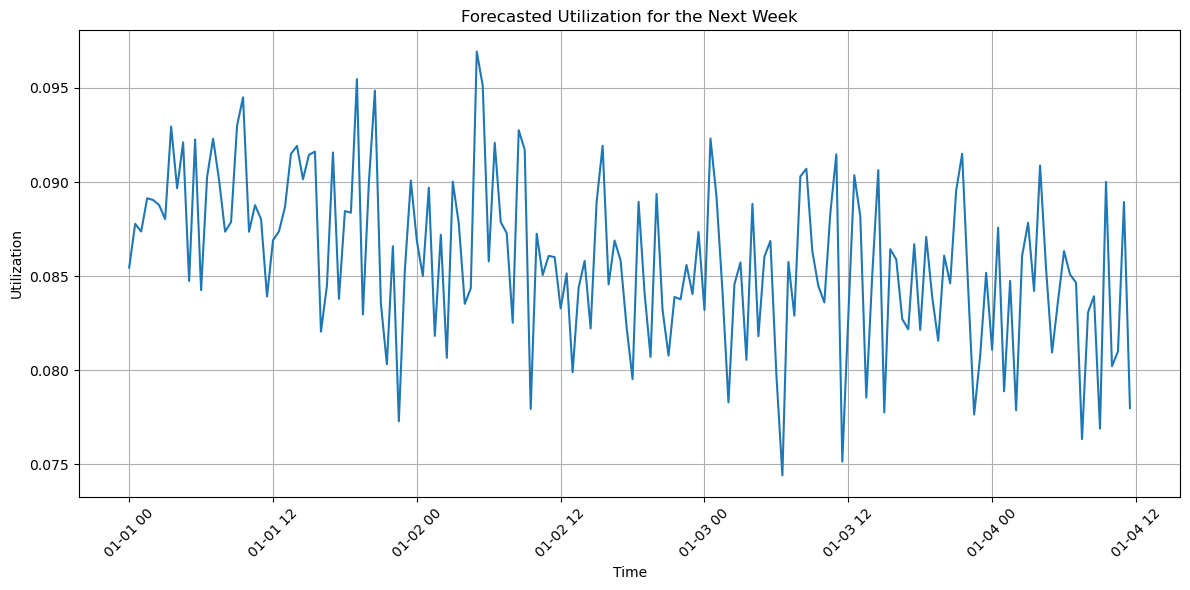

In [228]:
import matplotlib.pyplot as plt
import pandas as pd

# Time range for plotting
time_steps = pd.date_range(start="2023-01-01", periods=future_steps, freq="30min")  # Adjust the start date as needed

plt.figure(figsize=(12, 6))
plt.plot(time_steps, future_predictions, linestyle='-', color='tab:blue')
plt.title('Forecasted Utilization for the Next Week')
plt.xlabel('Time')
plt.ylabel('Utilization')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
